# Class Activation Map | EPOCH Lab: Ricoh

The concept of Class Activation Map was introduced by Zhou et al in the paper [Learning Deep Features for Discriminative Localization](https://arxiv.org/pdf/1512.04150v1.pdf). They use the term Class Activation Maps to refer to weighted activation maps generated by a CNN. These weighted activations lead to the prediction of a specific label for the image.

In [1]:
%pylab inline

import cv2
from PIL import Image
import torch
import torch.nn.functional as F
from torchvision import models, transforms

Populating the interactive namespace from numpy and matplotlib


In [2]:
print("CUDA Available: ", torch.cuda.is_available())
device = torch.device("cuda" if (torch.cuda.is_available()) else "cpu")

CUDA Available:  False


In [3]:
model = models.inception_v3(pretrained=True).to(device)
finalconv_name = 'Mixed_7c'

# model = models.resnet18(pretrained=True).to(device)
# finalconv_name = 'layer4'

# model = models.resnet50(pretrained=True).to(device)
# finalconv_name = 'layer4'

In [4]:
model.eval()

Inception3(
  (Conv2d_1a_3x3): BasicConv2d(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2a_3x3): BasicConv2d(
    (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2b_3x3): BasicConv2d(
    (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_3b_1x1): BasicConv2d(
    (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_4a_3x3): BasicConv2d(
    (conv): Conv2d(80, 192, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True, t

In [5]:
with open("data/LOC_synset_mapping.txt", "r") as f:
    classes = [s.strip() for s in f.readlines()]

In [6]:
preprocess = transforms.Compose([transforms.Resize(256),
                                 transforms.ToTensor(),
                                 transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
                                ])

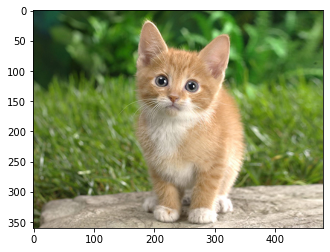

In [7]:
img = Image.open("/Volumes/artemis/library/datasets/cat.jpg")
plt.imshow(img)

In [8]:
input_tensor = preprocess(img).unsqueeze(0)
print(input_tensor.shape)

torch.Size([1, 3, 256, 341])


In [9]:
def class_activation(dim, feature_conv, weight_softmax, class_idx):
    b, c, h, w = feature_conv.shape
    
    maps = []
    
    for idx in class_idx:
        cam = weight_softmax[idx].dot(feature_conv.reshape((c, h*w)))
        
        cam = cam.reshape(h, w)
        
        cam = cam - np.min(cam)
        cam_img = cam / np.max(cam)
        cam_img = np.uint8(255*cam_img)

        maps.append(cv2.resize(cam_img, dim, interpolation=cv2.INTER_AREA))
    
    return maps

In [10]:
def hook_feature(module, inp, out):
    features_blobs.append(out.data.cpu().numpy())

In [11]:
features_blobs = []  
model._modules.get(finalconv_name).register_forward_hook(hook_feature)

parms = list(model.parameters())
weight_softmax = np.squeeze(parms[-2].data.numpy())

In [12]:
logit = model(input_tensor)

probs = F.softmax(logit, dim=1).data.squeeze()
acc, indices = probs.sort(0, True)

cam = class_activation(img.size, features_blobs[0], weight_softmax, indices)

tensor(0.9317) tensor(282) n02123159 tiger cat


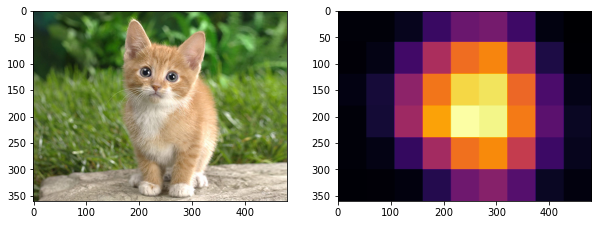

In [13]:
idx = 0

print(acc[idx], indices[idx], classes[indices[idx]])    

plt.figure(figsize=(10, 10))
plt.subplot(1, 2, 1)
plt.imshow(img)
plt.subplot(1, 2, 2)
plt.imshow(cam[idx], cmap=plt.cm.inferno)
plt.show()